In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ee
import requests
from google.oauth2 import service_account

# Initialize Earth Engine API
service_account_key = r'C:\Users\serafino\Desktop\Water Management System\ee-eugenioserafino01-dca7dda5348b.json'

# Define the required OAuth scope for Earth Engine
scopes = ['https://www.googleapis.com/auth/earthengine']

# Create credentials with the specified scope
credentials = service_account.Credentials.from_service_account_file(
    service_account_key, scopes=scopes
)

# Initialize Earth Engine with the credentials
ee.Initialize(credentials)


In [2]:
def get_soil_moisture_data(lat, lon, days_before_today, collection_id='NASA/SMAP/SPL4SMGP/007', band_name='sm_rootzone'):
    point = ee.Geometry.Point([lon, lat])
    end_date = ee.Date(datetime.now().strftime('%Y-%m-%d'))
    start_date = end_date.advance(-days_before_today, 'day')

    results = []
    current_date = start_date
    while current_date.difference(end_date, 'month').getInfo() < 0:
        next_date = current_date.advance(3, 'month')
        dataset = ee.ImageCollection(collection_id).filterDate(current_date, next_date).select(band_name)
        quarterly_data = dataset.map(lambda image: ee.Feature(
            point,
            {
                'date': image.date().format('YYYY-MM-dd'),
                'soil_moisture': image.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=point,
                    scale=1000
                ).get(band_name)
            }
        ))

        try:
            quarterly_data_list = quarterly_data.getInfo()['features']
            results.extend([{
                'date': feature['properties']['date'],
                'soil_moisture': feature['properties'].get('soil_moisture', None)
            } for feature in quarterly_data_list])
        except Exception as e:
            print(f"Error retrieving data for {current_date.format('YYYY-MM').getInfo()}: {e}")
        
        current_date = next_date

    soil_moisture_df = pd.DataFrame(results)
    soil_moisture_df['date'] = pd.to_datetime(soil_moisture_df['date'])
    soil_moisture_df.set_index('date', inplace=True)
    return soil_moisture_df


In [3]:
def get_weather_data(lat, lon, days_before_today):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_before_today)
    start_date_str = start_date.strftime('%Y%m%d')
    end_date_str = end_date.strftime('%Y%m%d')
    parameters = "T2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,RH2M,WS10M,PS"
    nasa_power_url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={parameters}"
        f"&community=AG&longitude={lon}&latitude={lat}"
        f"&start={start_date_str}&end={end_date_str}&format=JSON"
    )
    response = requests.get(nasa_power_url)
    weather_data = response.json()["properties"]["parameter"]

    dates = list(weather_data["T2M"].keys())
    weather_df = pd.DataFrame({
        'date': pd.to_datetime(dates, format='%Y%m%d'),
        'temperature': list(weather_data["T2M"].values()),
        'precipitation': list(weather_data["PRECTOTCORR"].values()),
        'irradiation': list(weather_data["ALLSKY_SFC_SW_DWN"].values()),
        'humidity': list(weather_data["RH2M"].values()),
        'wind_speed': list(weather_data["WS10M"].values()),
        'pressure': list(weather_data["PS"].values())
    })
    return weather_df

def get_ndvi_data(lat, lon, days_before_today):
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=days_before_today)).strftime('%Y-%m-%d')
    point = ee.Geometry.Point([lon, lat])
    ndvi_collection = ee.ImageCollection('MODIS/061/MOD13A1').filter(ee.Filter.date(start_date, end_date)).select('NDVI')

    ndvi_data = ndvi_collection.map(lambda image: ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'NDVI': image.reduceRegion(ee.Reducer.mean(), point, scale=500).get('NDVI')
    }))
    ndvi_list = ndvi_data.getInfo()['features']
    return pd.DataFrame({
        'date': pd.to_datetime([feature['properties']['date'] for feature in ndvi_list]),
        'ndvi': [feature['properties']['NDVI'] for feature in ndvi_list]
    })

def get_lst_data(lat, lon, days_before_today):
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=days_before_today)).strftime('%Y-%m-%d')
    point = ee.Geometry.Point([lon, lat])
    lst_collection = ee.ImageCollection('MODIS/061/MOD11A1').filter(ee.Filter.date(start_date, end_date)).select('LST_Day_1km')

    lst_data = lst_collection.map(lambda image: ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'LST_Day_1km': image.reduceRegion(ee.Reducer.mean(), point, scale=500).get('LST_Day_1km')
    }))
    lst_list = lst_data.getInfo()['features']
    lst_df = pd.DataFrame({
        'date': pd.to_datetime([feature['properties']['date'] for feature in lst_list]),
        'lst': [feature['properties'].get('LST_Day_1km', None) for feature in lst_list]
    })
    lst_df['lst'] = lst_df['lst'].interpolate(method='linear', limit_direction='both')
    return lst_df


In [9]:
# Define coordinates and date range
lat, lon = 45.25, 12.016  # Example coordinates for Pontelongo
days_before_today = 2000  # Past year

# Retrieve datasets
soil_moisture_df = get_soil_moisture_data(lat, lon, days_before_today)
weather_df = get_weather_data(lat, lon, days_before_today)
ndvi_df = get_ndvi_data(lat, lon, days_before_today)
lst_df = get_lst_data(lat, lon, days_before_today)

# Merge datasets
data = soil_moisture_df.join(weather_df.set_index('date'), on='date')
data = data.join(ndvi_df.set_index('date'), on='date')
data = data.join(lst_df.set_index('date'), on='date')
data.dropna(inplace=True)  # Drop rows with missing values


### Part 5: Preparing Data for the Random Forest Model

1. **Creating the Target Variable**:
   - The goal is to predict soil moisture for the next day. By shifting the `soil_moisture` column by one day, we set the soil moisture of the next day as our target variable. This way, the model can learn to predict future soil moisture based on today’s weather and environmental conditions.

2. **Features (`X`) and Labels (`y`)**:
   - `X` (features): This includes the various weather and environmental factors we believe influence soil moisture: temperature, precipitation, irradiation, humidity, wind speed, pressure, NDVI (Normalized Difference Vegetation Index), and LST (Land Surface Temperature).
   - `y` (label): The `target_soil_moisture` column, which is the soil moisture level for the following day.

3. **Train-Test Split**:
   - Splitting data into training and testing sets is crucial to evaluate the model’s ability to generalize. The model trains on 80% of the data (`X_train`, `y_train`) and is tested on the remaining 20% (`X_test`, `y_test`). 
   - This separation allows us to assess how well the model predicts unseen data, which gives an indication of its real-world performance.


In [5]:
# Shift soil moisture to create target variable for the next day
data['target_soil_moisture'] = data['soil_moisture'].shift(-1)
data.dropna(inplace=True)

# Define features and labels
X = data[['temperature', 'precipitation', 'irradiation', 'humidity', 'wind_speed', 'pressure', 'ndvi', 'lst']]
y = data['target_soil_moisture']

# Train-test split and normalization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Part 6: Building and Training the Random Forest Model

#### What is a Random Forest?
- A **Random Forest** is an ensemble learning technique that uses multiple decision trees to make predictions. Each tree is trained on a random subset of the data and learns to make predictions independently.
- When it’s time to make a prediction, each tree “votes” (in regression, it averages the predictions), and the Random Forest outputs the overall result.
- This approach reduces **overfitting** (a common problem in single decision trees) by combining the outputs of multiple trees, each with different perspectives due to the randomness introduced during training.

#### Key Parameters
- **n_estimators**: This is the number of trees in the forest. A higher number of trees generally improves performance but also increases computational cost.
- **random_state**: Setting a random seed ensures reproducibility. If you use the same seed, you’ll get the same results each time you run the code.

#### Training the Model
- During training, each tree in the forest learns patterns between the input features (weather and environmental data) and the target variable (next day’s soil moisture).
- Each tree is built by splitting the data at various points based on criteria that minimize the prediction error (e.g., minimizing mean squared error).
- By averaging predictions across multiple trees, the forest can capture complex relationships without being overly sensitive to specific data points.


In [6]:
# Define the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)


### Part 7: Evaluating the Model

#### Making Predictions
- After training, the model’s performance is evaluated by predicting soil moisture values for the `X_test` dataset (the 20% of data that wasn’t used in training).
- We then compare these predictions to the actual values in `y_test`.

#### Mean Absolute Error (MAE)
- **MAE** is used to quantify the model’s performance. It calculates the average absolute difference between predicted values and actual values.
  - Formula: \(\text{MAE} = \frac{1}{n} \sum |y_{\text{true}} - y_{\text{pred}}|\)
  - This metric is in the same unit as the target variable (e.g., soil moisture level), making it easy to interpret.
  - A lower MAE indicates better model performance, as it means the average prediction error is small.


In [7]:
# Evaluate model performance on test set
y_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {test_mae}")


Test MAE: 0.006612669196027603


### Part 8: Making Predictions and Analyzing Feature Importance

#### Predicting for the Next Day
- We use the most recent available data (the last row of `X`) to predict soil moisture for the following day. This allows us to make a near-term prediction based on the latest environmental conditions.
  
#### Interpreting Feature Importance
- **Feature Importance**: This is a measure of how much each feature contributes to the model’s predictions.
- In a Random Forest model, feature importance is calculated by assessing the decrease in prediction error when a feature is used in a tree’s splits.
  - If a feature is critical in making accurate predictions, using it will significantly decrease the error, and it will have a higher importance score.
  - Conversely, if a feature doesn’t affect predictions much, it will have a lower importance score.

#### Interpreting the Results of Feature Importance:
- **Bar Plot of Feature Importance**: A visual representation of feature importance helps identify which variables most influence soil moisture predictions.
  - For example, if **precipitation** has a high importance score, it suggests that soil moisture is highly dependent on recent rainfall.
  - This can guide further analysis or even future data collection—if certain variables have low importance, they may not be necessary for this specific predictive model.


Predicted soil moisture for the next day: 0.24722528174287514


c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


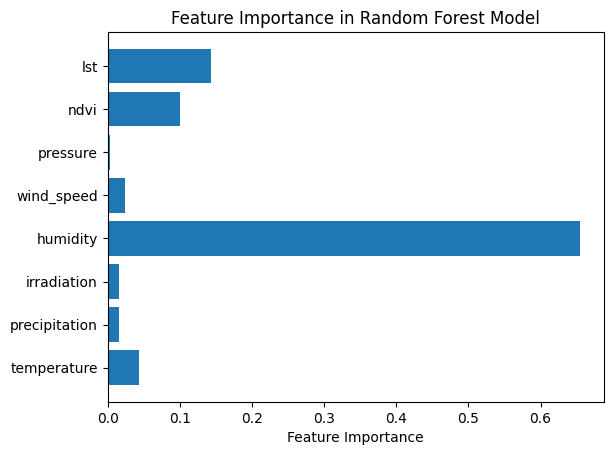

In [8]:
# Predict soil moisture for the next day
latest_data = data.iloc[-1][['temperature', 'precipitation', 'irradiation', 'humidity', 'wind_speed', 'pressure', 'ndvi', 'lst']].values.reshape(1, -1)
predicted_moisture = model.predict(latest_data)
print(f"Predicted soil moisture for the next day: {predicted_moisture[0]}")

# Optional: Feature Importance Plot
importances = model.feature_importances_
feature_names = X.columns
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest Model")
plt.show()



### How to Interpret the Overall Results

1. **Evaluate MAE**:
   - A low MAE means the model has learned meaningful patterns in the data and makes predictions close to the actual values.
   - If the MAE is high, the model might need more data, different features, or hyperparameter tuning to improve accuracy.

2. **Interpret Feature Importance**:
   - High importance scores for certain features indicate strong correlations with soil moisture. For instance, if **humidity** has a high score, it likely plays a key role in determining soil moisture.
   - This insight is valuable for understanding the relationships in your data and can inform decisions in other areas, such as agricultural planning or resource allocation.

3. **Using the Predicted Moisture**:
   - The predicted soil moisture for the next day can help in making informed decisions, such as adjusting irrigation schedules to conserve water resources.

In summary, this Random Forest model not only provides predictions but also reveals insights into which environmental factors most affect soil moisture. This information can enhance both short-term decision-making and long-term planning in agriculture and water resource management.
